In [1]:
import wget
import os
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from astropy.io import fits

In [2]:
# We download the foreground 
url = "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_synchrotron-ffp10-skyinbands-143_2048_R3.00_full.fits"
filename = 'Foreground.fits'

if not os.path.exists(filename):
    wget.download(url, filename)
else:
    print("File already exists")

In [3]:
hdul = fits.open(filename)

hdul.info()

data = hdul[0].data
header = hdul[0].header

primary_data = hdul[0].data
primary_header = hdul[0].header

signal_data = hdul[1].data
signal_header = hdul[1].header
hdul.close()

Filename: Foreground.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  SIGNAL        1 BinTableHDU     58   49152R x 3C   [1024D, 1024D, 1024D]   


In [4]:
foreground_T_data = signal_data['TEMPERATURE']
foreground_Q_data = signal_data['Q_POLARISATION']
foreground_U_data = signal_data['U_POLARISATION']

In [5]:
foreground_T_data_1d = foreground_T_data.flatten()
foreground_Q_data_1d = foreground_Q_data.flatten()
foreground_U_data_1d = foreground_U_data.flatten()

#### **Check fwhm**

In [6]:
TT_cl, EE_cl, BB_cl, TE_cl, EB_cl, TB_cl = hp.anafast([foreground_T_data_1d, foreground_Q_data_1d, foreground_U_data_1d], pol=True, alm = False)

In [7]:
ell = np.arange(len(TT_cl))

In [8]:
A = 10**-10.88

In [9]:
def arcmin2rad(arcmin):
    return arcmin * np.pi / (60 * 180)

In [10]:
# Beams at different arcminutes
beam_74 = hp.sphtfunc.gauss_beam(fwhm=arcmin2rad(7.4), lmax=np.max(ell), pol=False)
beam_5 = hp.sphtfunc.gauss_beam(fwhm=arcmin2rad(5), lmax=np.max(ell), pol=False)

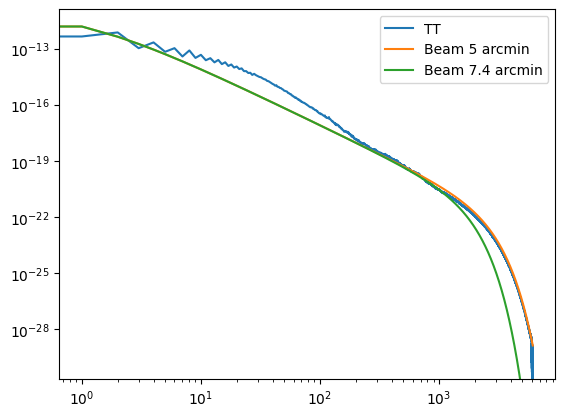

In [11]:
plt.plot(ell, TT_cl, label='TT')
plt.plot(A * ell[1:]**(-3.1) * beam_5[1:]**2, label = 'Beam 5 arcmin')
plt.plot(A * ell[1:]**(-3.1) * beam_74[1:]**2, label = 'Beam 7.4 arcmin')
plt.ylim(np.min(TT_cl), np.max(TT_cl))
plt.legend()
plt.loglog()
plt.show()

The foreground simulation data we downloaded was for a 5 arcmin beam. We have to adapt it to our veam, 7.4 arcmin

#### **Correct for fwhm**

In [12]:
%store -r nside

In [13]:
fwhm_arcmin = np.sqrt(7.4**2-5**2)
fwhm = arcmin2rad(fwhm_arcmin)

In [14]:
foreground_alm_T, foreground_alm_E, foreground_alm_B = hp.map2alm([foreground_T_data_1d, foreground_Q_data_1d, foreground_U_data_1d], pol=True)

In [15]:
foreground_map_T, foreground_map_Q, foreground_map_U = hp.alm2map([foreground_alm_T, foreground_alm_E, foreground_alm_B], nside, fwhm=fwhm, pol = True)

In [16]:
[foreground_map_T, foreground_map_Q, foreground_map_U] = [i * (27/143)**(-3.1) for i in [foreground_map_T, foreground_map_Q, foreground_map_U]]

In [17]:
%store foreground_map_Q
%store foreground_map_U

Stored 'foreground_map_Q' (ndarray)
Stored 'foreground_map_U' (ndarray)


In [18]:
# Now for E and B maps
foreground_map_E = hp.alm2map(foreground_alm_E, nside, fwhm=fwhm)
foreground_map_B = hp.alm2map(foreground_alm_B, nside, fwhm=fwhm)

In [19]:
[foreground_map_E, foreground_map_B] = [i * (27/143)**(-3.1) for i in [foreground_map_E, foreground_map_B]]

In [20]:
%store foreground_map_E
%store foreground_map_B

Stored 'foreground_map_E' (ndarray)
Stored 'foreground_map_B' (ndarray)


Acabas de descubrir el poder de la Gaussianidad e isotropía estadística. hp.synfast está pensado para generar realizaciones aleatorias de un campo isótropo y Gaussiano con el espectro de potencias que tú quieras. Así que tu foreground_map_TQU es la versión Gaussiana e isótropa de foreground_TQU_data_1d. Si te calculases su espectro de potencias, verías que es compatible con el original (i.e., foreground_map_TQU tiene las correlaciones adecuadas), pero ha perdido toda la estructura anisótropa (ya no se concentra en torno al plano galáctico) y de filamentos del mapa original. Esto es porque los foregrounds son a la vez altamente anisótropos y no Gaussianos, lo que hace que sea muy difícil simularlos. De hecho, solo tenemos una plantilla de emisión proveniente de los datos (el mapa que te has descargado) para añadir a las simulaciones